# Import Libraries and set GPU usage

In [1]:
import numpy as np
import pandas as pd
#import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
# specify GPU
import torch

# Set PyTorch to use a specific GPU, e.g., the second GPU
torch.cuda.set_device(2)  # Device numbers are zero-indexed, 1 refers to the second GPU

device = torch.device("cuda")  # This will now use the GPU you specified with set_device

# You can check if the right device is set
print("Using device:", device)
print("Current device:", torch.cuda.current_device())



Using device: cuda
Current device: 2


# Data Exploration

In [2]:
data=pd.read_csv("WELFake_Dataset.csv")
print(data.shape)
print(data)

(72134, 4)
       Unnamed: 0                                              title  \
0               0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1               1                                                NaN   
2               2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3               3  Bobby Jindal, raised Hindu, uses story of Chri...   
4               4  SATAN 2: Russia unvelis an image of its terrif...   
...           ...                                                ...   
72129       72129  Russians steal research on Trump in hack of U....   
72130       72130   WATCH: Giuliani Demands That Democrats Apolog...   
72131       72131  Migrants Refuse To Leave Train At Refugee Camp...   
72132       72132  Trump tussle gives unpopular Mexican leader mu...   
72133       72133  Goldman Sachs Endorses Hillary Clinton For Pre...   

                                                    text  label  
0      No comment is expected from Barack Obama Membe...  

<AxesSubplot: >

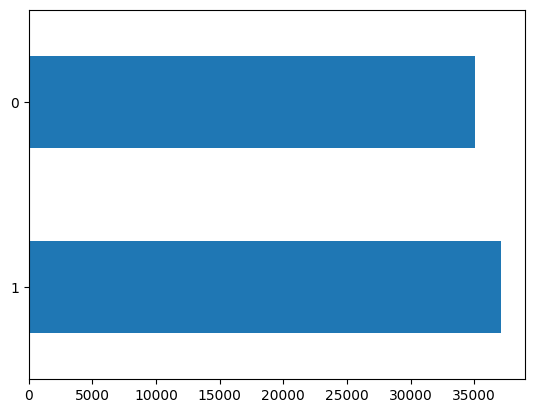

In [3]:
data['label'].value_counts().plot(kind='barh')

/tmp/ipykernel_4108595/1772383746.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_data['Target'] = 0
/tmp/ipykernel_4108595/1772383746.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_data['Target'] = 1


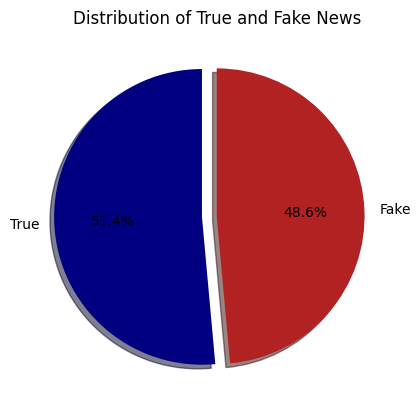

,Unnamed: 0,title,text,label,Target
0,8728,"WOW! MACON, GA RESIDENT SLAMS Rep John Lewis: ...",Young black man delivers poignant message to ...,0,False
1,53682,British Alignment With Trump Threatens Europea...,LONDON — As American allies across Europe a...,1,True
2,3655,Four-time Deportee Busted at Texas Border,A criminal illegal immigrant who was deported ...,1,True
3,21373,BLACK LIVES MATTER RESPONDS TO Oakland Police ...,Proving that they really don t want anything t...,0,False
4,52923,BREAKING: US SUPREME COURT RULES King Obama Ov...,Don t let the door hit ya B..b..but who will b...,0,False


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' contains your DataFrame with the 'label' column
# Separate the data into 'true_data' and 'fake_data' based on the 'label' column
true_data = data[data['label'] == 1]  # Filtering for rows where 'label' is 1
fake_data = data[data['label'] == 0]  # Filtering for rows where 'label' is 0

# Add a 'Target' column to 'true_data' and 'fake_data'
true_data['Target'] = 0
fake_data['Target'] = 1

# Merge 'true_data' and 'fake_data' into a single DataFrame 'merged_data' with random mixing
merged_data = pd.concat([true_data, fake_data]).sample(frac=1).reset_index(drop=True)
merged_data['Target'] = merged_data['label'].map({0: True, 1: False})
merged_data['Target'] = merged_data['Target'].astype(str)
# Convert label 0 to 1 and label 1 to 0
merged_data['label'] = merged_data['label'].map({0: 1,1: 0})

#merged_data['Target'] = merged_data['Target'].astype(int)

# Convert 'title' and 'text' columns to strings
merged_data['title'] = merged_data['title'].astype(str)
merged_data['text'] = merged_data['text'].astype(str)

# Checking if our data is well balanced
label_sizes = merged_data['Target'].value_counts()
plt.pie(label_sizes, explode=[0.1, 0], colors=['navy', 'firebrick'], startangle=90, shadow=True,
        labels=['True', 'Fake'], autopct='%1.1f%%')
plt.title('Distribution of True and Fake News')
plt.show()

merged_data.head()  # Show the first few rows of the merged DataFrame


# Loading Model

We load a pretrained BERT model, and apply transfer learning.

In [5]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(merged_data['title'], merged_data['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=merged_data['Target'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Text(0, 0.5, 'Number of texts')

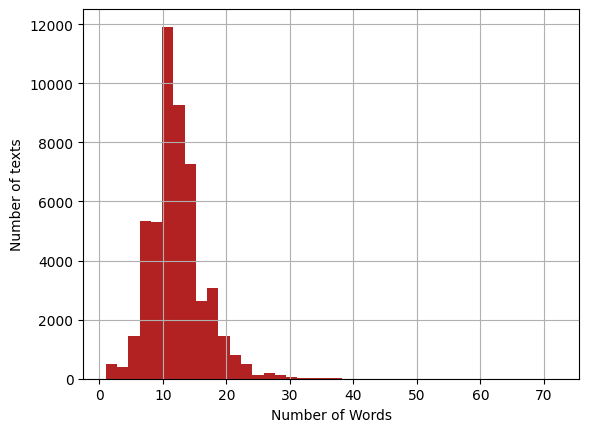

In [6]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]
pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [7]:
# Majority of titles above have word length under 30. So, we set max title length as 30
MAX_LENGHT = 30
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 10                                               #define a batch size
train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set


/media/ntu/volume1/home/s123md305_01/anaconda3/envs/stylegan/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [8]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

In [9]:
import gc
gc.collect()
class BERT_Arch(nn.Module):
    def __init__(self, bert):  
      super(BERT_Arch, self).__init__()
      self.bert = bert   
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass  
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x
model = BERT_Arch(bert)
model.to(device)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss() 
# Number of training epochs
epochs = 5

2024-04-17 14:53:53.553630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 14:53:53.865978: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 14:53:54.741789: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-17 14:53:54.741933: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [10]:
# Defining training and evaluation functions
def train():  
  model.train()
  total_loss, total_accuracy = 0, 0
  
  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = [b.to(device) for b in batch]
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch  
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():  
  print("\nEvaluating...")  
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0  
  for step,batch in enumerate(val_dataloader):    # Iterate over batches  
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.     
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = [b.to(device) for b in batch]
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

# Train Model

In [26]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'bert.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50  of  5,050.
  Batch   100  of  5,050.
  Batch   150  of  5,050.
  Batch   200  of  5,050.
  Batch   250  of  5,050.
  Batch   300  of  5,050.
  Batch   350  of  5,050.
  Batch   400  of  5,050.
  Batch   450  of  5,050.
  Batch   500  of  5,050.
  Batch   550  of  5,050.
  Batch   600  of  5,050.
  Batch   650  of  5,050.
  Batch   700  of  5,050.
  Batch   750  of  5,050.
  Batch   800  of  5,050.
  Batch   850  of  5,050.
  Batch   900  of  5,050.
  Batch   950  of  5,050.
  Batch 1,000  of  5,050.
  Batch 1,050  of  5,050.
  Batch 1,100  of  5,050.
  Batch 1,150  of  5,050.
  Batch 1,200  of  5,050.
  Batch 1,250  of  5,050.
  Batch 1,300  of  5,050.
  Batch 1,350  of  5,050.
  Batch 1,400  of  5,050.
  Batch 1,450  of  5,050.
  Batch 1,500  of  5,050.
  Batch 1,550  of  5,050.
  Batch 1,600  of  5,050.
  Batch 1,650  of  5,050.
  Batch 1,700  of  5,050.
  Batch 1,750  of  5,050.
  Batch 1,800  of  5,050.
  Batch 1,850  of  5,050.
  Batch 1,900  of  5,050

  Batch 3,400  of  5,050.
  Batch 3,450  of  5,050.
  Batch 3,500  of  5,050.
  Batch 3,550  of  5,050.
  Batch 3,600  of  5,050.
  Batch 3,650  of  5,050.
  Batch 3,700  of  5,050.
  Batch 3,750  of  5,050.
  Batch 3,800  of  5,050.
  Batch 3,850  of  5,050.
  Batch 3,900  of  5,050.
  Batch 3,950  of  5,050.
  Batch 4,000  of  5,050.
  Batch 4,050  of  5,050.
  Batch 4,100  of  5,050.
  Batch 4,150  of  5,050.
  Batch 4,200  of  5,050.
  Batch 4,250  of  5,050.
  Batch 4,300  of  5,050.
  Batch 4,350  of  5,050.
  Batch 4,400  of  5,050.
  Batch 4,450  of  5,050.
  Batch 4,500  of  5,050.
  Batch 4,550  of  5,050.
  Batch 4,600  of  5,050.
  Batch 4,650  of  5,050.
  Batch 4,700  of  5,050.
  Batch 4,750  of  5,050.
  Batch 4,800  of  5,050.
  Batch 4,850  of  5,050.
  Batch 4,900  of  5,050.
  Batch 4,950  of  5,050.
  Batch 5,000  of  5,050.

Evaluating...
  Batch    50  of  1,082.
  Batch   100  of  1,082.
  Batch   150  of  1,082.
  Batch   200  of  1,082.
  Batch   250  of  1,08

# Load Trained Model

For testing purposes, please download the trained BERT model, 'bert.pt' from our GitHub link and load it.

              precision    recall  f1-score   support

           0       0.87      0.78      0.83      5566
           1       0.79      0.88      0.83      5255

    accuracy                           0.83     10821
   macro avg       0.83      0.83      0.83     10821
weighted avg       0.83      0.83      0.83     10821



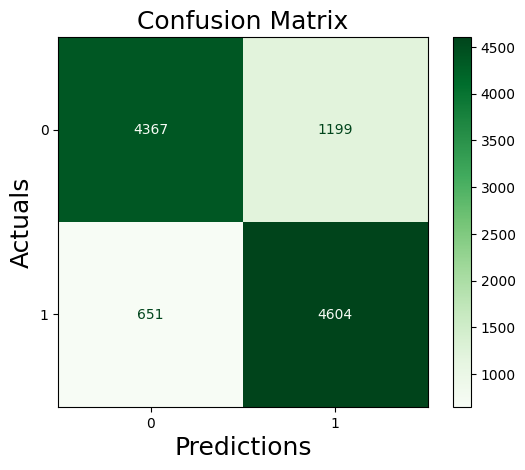

In [12]:
# load weights of best model
import torch
torch.cuda.empty_cache()
path = 'bert.pt'
model.load_state_dict(torch.load(path, map_location=device))

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    # Ensure test_seq and test_mask are on the same device as model
    test_seq = test_seq.to(device)
    test_mask = test_mask.to(device)

    preds = model(test_seq, test_mask)
    # If your model returns a tuple, ensure to get the right output for predictions
    # preds = preds[0] if isinstance(preds, tuple) else preds
    preds = preds.detach().cpu().numpy()  # Move predictions back to CPU for further operations

preds = np.argmax(preds, axis=1)

# Assuming test_y is a numpy array or a tensor. If it's a tensor, ensure it's on CPU
if isinstance(test_y, torch.Tensor):
    test_y = test_y.cpu().numpy()

print(classification_report(test_y, preds))
conf_matrix = confusion_matrix(test_y, preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Unseen Testing

Change the text in unseen_news_text, and run this cell to evaluate.

In [14]:
# testing on unseen data
unseen_news_text = ["Baltimore bridge collapses after S’pore-flagged ship collision; search under way for survivors",     # Fake
                    "You Can Smell Hillary’s Fear",               # Fake
                    "Watch The Exact Moment Paul Ryan Committed Political Suicide At A Trump Rally (VIDEO)",           # True
                    "New Changi Heritage Trail documents area's military, recreational and social history"]
# tokenize and encode sequences in the test set
MAX_LENGHT = 30
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])
unseen_seq = unseen_seq.to(device)
unseen_mask = unseen_mask.to(device)

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()


preds = np.argmax(preds, axis=1)

# Convert numeric predictions to 'True' or 'False' strings
preds = np.where(preds == 1, 'True', 'False')

# Now print the predictions
print(preds)


['True' 'False' 'False' 'True']


# Blind Testing Exploratory Analysis

In [15]:
data=pd.read_csv("news.csv")
print(data.shape)
print(data)

(6335, 4)
      Unnamed: 0                                              title  \
0           8476                       You Can Smell Hillary’s Fear   
1          10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2           3608        Kerry to go to Paris in gesture of sympathy   
3          10142  Bernie supporters on Twitter erupt in anger ag...   
4            875   The Battle of New York: Why This Primary Matters   
...          ...                                                ...   
6330        4490  State Department says it can't find emails fro...   
6331        8062  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...   
6332        8622  Anti-Trump Protesters Are Tools of the Oligarc...   
6333        4021  In Ethiopia, Obama seeks progress on peace, se...   
6334        4330  Jeb Bush Is Suddenly Attacking Trump. Here's W...   

                                                   text label  
0     Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1     Goo

/tmp/ipykernel_4108595/1828736818.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_data['Target'] = 0
/tmp/ipykernel_4108595/1828736818.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_data['Target'] = 1


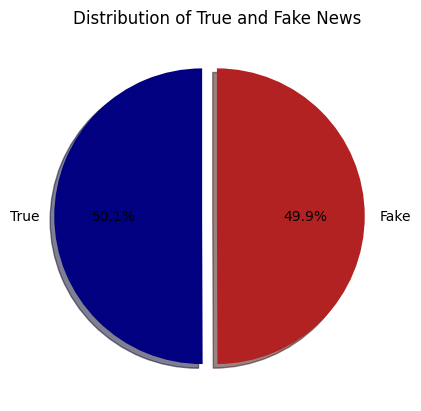

,Unnamed: 0,title,text,label,Target
0,5109,The Daily 202: Why Trump sounded more like a s...,CLEVELAND—You could be forgiven for wanting to...,1,True
1,5569,Three Ways to Recharge Your Energy Using Crystals,by Tanaaz \nCrystals are a great tool for heal...,0,False
2,7601,The Trump effect: Jack in the box and Obama's ...,The Trump effect: Jack in the box and Obama's ...,0,False
3,4628,"Post-ABC poll finds tight presidential race, w...",Republicans' growing unity behind their presid...,1,True
4,5854,"Professor Shares Insights on Paranormal, Canni...","Professor Shares Insights on Paranormal, Canni...",0,False


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' contains the DataFrame with the 'label' column
# Separate the data into 'true_data' and 'fake_data' based on the 'label' column
true_data = data[data['label'] == 'REAL']  # Filtering for rows where 'label' is 1
fake_data = data[data['label'] == 'FAKE']  # Filtering for rows where 'label' is 0

# Add a 'Target' column to 'true_data' and 'fake_data'
true_data['Target'] = 0
fake_data['Target'] = 1

# Merge 'true_data' and 'fake_data' into a single DataFrame 'merged_data' with random mixing
merged_data = pd.concat([true_data, fake_data]).sample(frac=1).reset_index(drop=True)
merged_data['Target'] = merged_data['label'].map({'REAL': True, 'FAKE': False})
merged_data['Target'] = merged_data['Target'].astype(str)
# Convert label 0 to 1 and label 1 to 0
merged_data['label'] = merged_data['label'].map({'REAL': 1,'FAKE': 0})

#merged_data['Target'] = merged_data['Target'].astype(int)

# Convert 'title' and 'text' columns to strings
merged_data['title'] = merged_data['title'].astype(str)
merged_data['text'] = merged_data['text'].astype(str)

# Checking if our data is well balanced
label_sizes = merged_data['Target'].value_counts()
plt.pie(label_sizes, explode=[0.1, 0], colors=['navy', 'firebrick'], startangle=90, shadow=True,
        labels=['True', 'Fake'], autopct='%1.1f%%')
plt.title('Distribution of True and Fake News')
plt.show()

merged_data.head()  # Show the first few rows of the merged DataFrame


<AxesSubplot: >

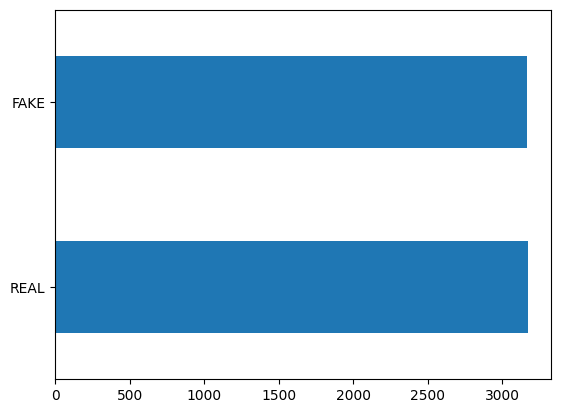

In [17]:
data['label'].value_counts().plot(kind='barh')

# Conduct Blind Testing

/media/ntu/volume1/home/s123md305_01/anaconda3/envs/stylegan/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


              precision    recall  f1-score   support

           0       0.58      0.62      0.60      3164
           1       0.59      0.54      0.57      3171

    accuracy                           0.58      6335
   macro avg       0.58      0.58      0.58      6335
weighted avg       0.58      0.58      0.58      6335



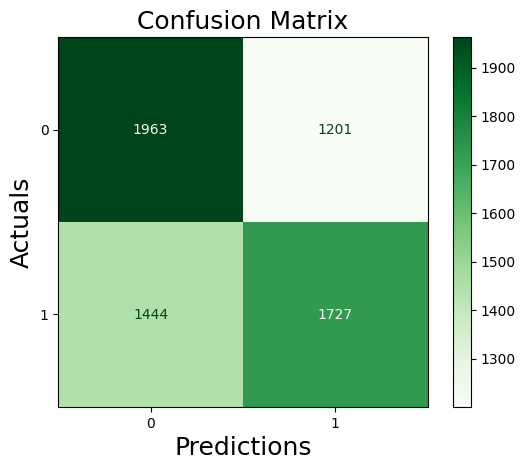

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import numpy as np
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader

# Assuming merged_data is your DataFrame with 'title' and 'label' columns

# Tokenize and encode the dataset
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased') # Use the same tokenizer as before
test_text = merged_data['title']
test_labels = merged_data['label']

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    # Ensure test_seq and test_mask are on the same device as model
    test_seq = test_seq.to(device)
    test_mask = test_mask.to(device)

    preds = model(test_seq, test_mask)
    # If your model returns a tuple, ensure to get the right output for predictions
    # preds = preds[0] if isinstance(preds, tuple) else preds
    preds = preds.detach().cpu().numpy()  # Move predictions back to CPU for further operations

preds = np.argmax(preds, axis=1)

# Assuming test_y is a numpy array or a tensor. If it's a tensor, ensure it's on CPU
if isinstance(test_y, torch.Tensor):
    test_y = test_y.cpu().numpy()

print(classification_report(test_y, preds))
conf_matrix = confusion_matrix(test_y, preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()